In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss, 
                             classification_report)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      RandomForestClassifier as RFC,
      BaggingClassifier as BC,
      GradientBoostingRegressor as GBR, 
      GradientBoostingClassifier as GBC)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.linear_model as skl
from sklearn.cross_decomposition import PLSRegression
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
from sklearn.neighbors import KNeighborsClassifier

import ipywidgets

### Problem 8

In [2]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

Carseats["Sales"] = High
Carseats["Sales"] = Carseats["Sales"].map({'No':0, 'Yes': 1})
Y = Carseats['Sales']

model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

split = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=42)

for train_index, test_index in split.split(D):
    X_train, X_test = D.iloc[train_index], D.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

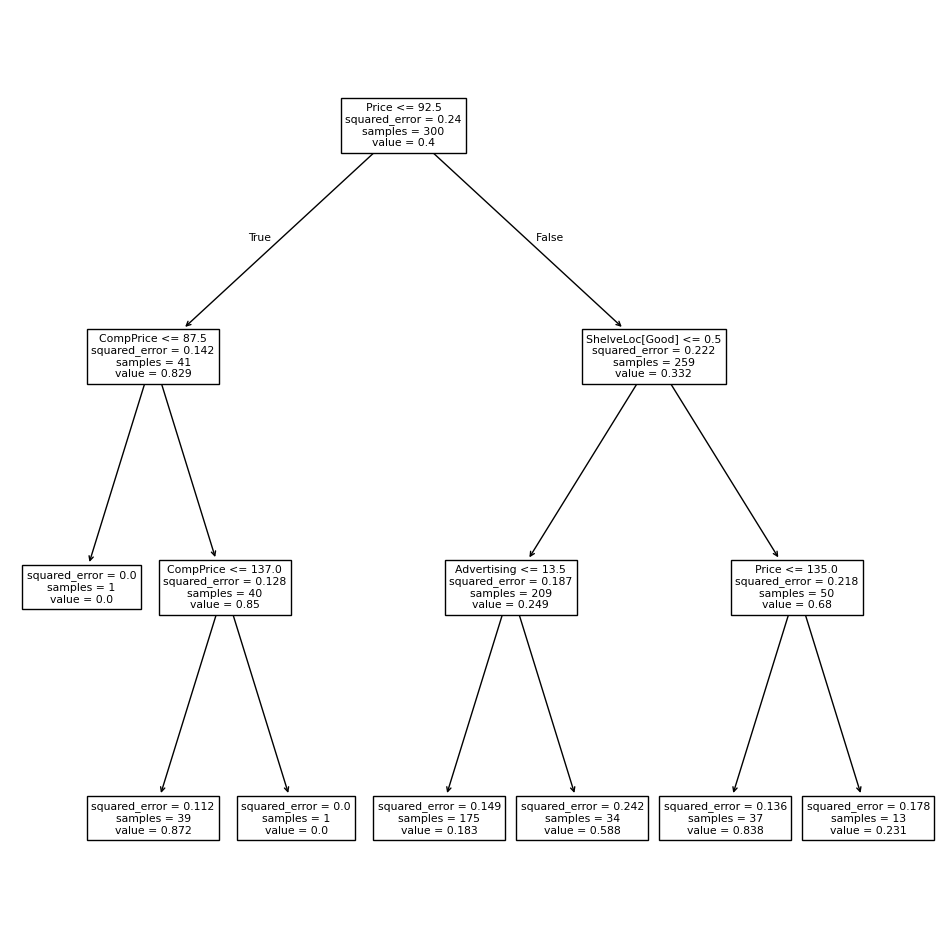

In [3]:
reg = DTR(max_depth=3)
reg.fit(X_train, Y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [4]:
np.mean((Y_test - reg.predict(X_test))**2)

0.2234603527516314

In [5]:
ccp_path = reg.cost_complexity_pruning_path(X_train, Y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, Y_train)
best_ = grid.best_estimator_
np.mean((Y_test - best_.predict(X_test))**2)

0.18518338592209815

YES! Prunning does improve the tree's performance and MSE 

In [6]:
bag_carseats = RF(n_estimators = 500, max_features=X_train.shape[1], random_state=42).fit(X_train, Y_train)
y_hat_bag = bag_carseats.predict(X_test)
np.mean((Y_test - y_hat_bag)**2)

0.14718996

Bagging also improves the MSE 

In [7]:
feature_imp = pd.DataFrame(
    {'importance':bag_carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.287279
CompPrice,0.132088
ShelveLoc[Good],0.112634
Age,0.110555
Advertising,0.110485
Income,0.078378
Population,0.064074
ShelveLoc[Medium],0.041171
Education,0.039169
US[Yes],0.013665


In [8]:
RF_carseats = RF(max_features=4, random_state=42).fit(X_train, Y_train)
y_hat_RF = RF_carseats.predict(X_test)
np.mean((Y_test - y_hat_RF)**2)

0.14946500000000001

WORSE!

In [9]:
feature_imp = pd.DataFrame(
    {'importance':RF_carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.244866
Age,0.123518
CompPrice,0.113973
Advertising,0.113413
ShelveLoc[Good],0.097685
Income,0.094568
Population,0.088132
Education,0.055020
ShelveLoc[Medium],0.033529
Urban[Yes],0.018048


Age, Advertising more considered here 

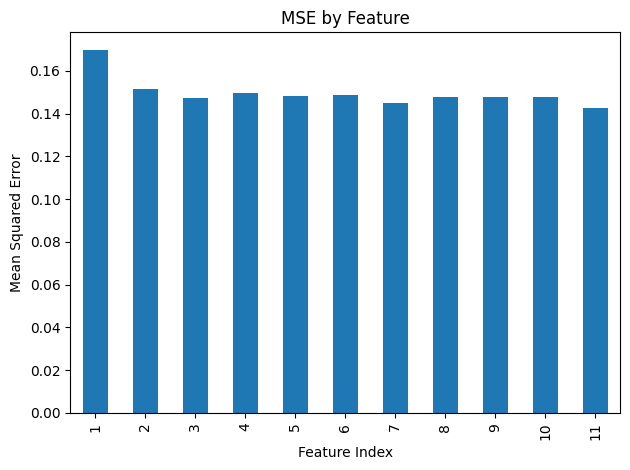

In [ ]:
MSEs = []
for i in range(1, X_train.shape[1]+1):
    RF_carseats = RF(max_features=i, random_state=42).fit(X_train, Y_train)
    y_hat_RF = RF_carseats.predict(X_test)
    MSEs.append(np.mean((Y_test - y_hat_RF)**2))

MSE = pd.DataFrame({"MSE": MSEs}, index=range(1, X_train.shape[1] + 1))


MSE.plot(kind='bar', legend=False)
plt.xlabel("Feature Index")
plt.ylabel("Mean Squared Error")
plt.title("MSE by Feature")
plt.tight_layout()
plt.show()


BART using other method from PyMC 

In [17]:
with pm.Model() as model:
    X_shared = pm.MutableData("X_shared", X_train)  # Placeholder for X

    mu = pmb.BART("mu", X_shared, Y_train, m=25)
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_train)

with model:
    trace = pm.sample(500, tune=250, chains=2, target_accept=0.9, random_seed=42)


c:\Users\campz\anaconda3\envs\ISLP\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Output()

Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 506 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [21]:
pm.set_data({"X_shared": X_test}, model=model)

with model:
    post_pred_test = pm.sample_posterior_predictive(trace, var_names=["mu"])

mu_samples = post_pred_test.posterior_predictive["mu"].values  # shape: (chains, draws, samples)

# Average over all posterior samples (flatten chains × draws)
y_test_pred = mu_samples.mean(axis=(0, 1))

rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred))
print("Test RMSE:", rmse)

Sampling: [mu]


Output()

Test RMSE: 0.3837347510189988


### Problem 10 

In [22]:
Hitters = load_data("Hitters")

Hitters = Hitters.dropna(subset = ["Salary"])
Hitters["Salary"] = np.log(Hitters["Salary"])

In [119]:

X = MS(Hitters.columns.drop("Salary"),intercept=False).fit(Hitters)
X = X.transform(Hitters)
features_names = list(X.columns)

X_train = X.iloc[:200]
Y_train = Hitters["Salary"].iloc[:200]

X_test = X.iloc[200:]
Y_test = Hitters["Salary"].iloc[200:]

In [111]:
lamdas = np.linspace(0.01, 0.1, 20)
MSEtrain = []
MSEtest = []


for lam in lamdas:
    gbr = GBR(n_estimators=1000, learning_rate=lam, max_depth=3, random_state=0)
    cv_scores = cross_val_score(gbr, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    gbr.fit(X_train, Y_train)
    MSEtrain.append(np.mean((Y_train - gbr.predict(X_train))**2))
    MSEtest.append(-cv_scores.mean())



Text(0.04, 0.5, 'MSE')

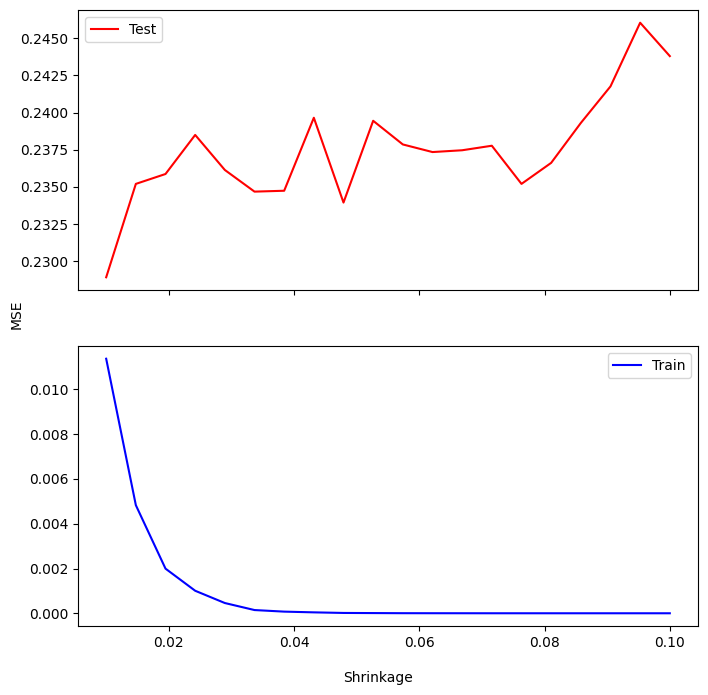

In [112]:
fig, (ax1, ax2) = subplots(2,1,figsize = (8,8), sharex = True)
ax1.plot(lamdas,
        MSEtest,
        'r',
        label='Test')
ax2.plot(lamdas,
        MSEtrain,
        'b',
        label='Train')
ax1.legend()
ax2.legend()
fig.text(0.5, 0.04, 'Shrinkage', ha='center')       
fig.text(0.04, 0.5, 'MSE', va='center', rotation='vertical') 

In [113]:
print(f"Optimal lamda according to Boosting: {lamdas[np.argmin(MSEtest)]:.5f}, Test MSE: {np.min(MSEtest):.5f}")

Optimal lamda according to Boosting: 0.01000, Test MSE: 0.22891


In [120]:
gbr = GBR(n_estimators=1000, learning_rate=lamdas[np.argmin(MSEtest)], max_depth=3, random_state=0).fit(X_train, Y_train)
feature_imp = pd.DataFrame(
    {'importance':gbr.feature_importances_},
    index=features_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
CAtBat,0.532575
CHits,0.096833
CRuns,0.053310
AtBat,0.049919
Walks,0.044501
CRBI,0.037391
CHmRun,0.034798
CWalks,0.033981
Years,0.028607
Hits,0.025714


Compare to lasso

In [114]:
scaler = StandardScaler()
lambdas = 10**np.linspace(-0.5, -3, 100)

lassoCV = skl.ElasticNetCV(alphas = lambdas, cv = 5, l1_ratio=1)
pipe2 = Pipeline(steps = [('scale',  scaler), ("lassoCV",  lassoCV)])
pipe2.fit(X_train, Y_train)

MSELasso = mean_squared_error(Y_test, pipe2.predict(X_test))

print(f"Optimal lambda according to Lasso: {pipe2.named_steps["lassoCV"].alpha_:.5f}, MSE: {MSELasso:.2f}")


Optimal lambda according to Lasso: 0.03275, MSE: 0.46


Compare to PLS 

In [106]:
pls = PLSRegression(n_components = 2, scale = True)
param_grid = {"n_components": range(1,18)}


grid = skm.GridSearchCV(pls, param_grid, cv = kfold, scoring = "neg_mean_squared_error")

grid.fit(X_train, Y_train)

y_pred = grid.predict(X_test)
mse_PLS = mean_squared_error(Y_test, y_pred)
print(f"Optimal components for PLS: {grid.best_estimator_}, Test MSE: {mse_PLS:.5f}")

Optimal components for PLS: PLSRegression(n_components=11), Test MSE: 0.47989


In [115]:
bag_hitters = RF(n_estimators = 500, max_features=X_train.shape[1], random_state=42).fit(X_train, Y_train)
y_hat_bag = bag_hitters.predict(X_test)
print(f"Test MSE for bagging: {mean_squared_error(Y_test, y_hat_bag):.4f}")

Test MSE for bagging: 0.2289


### Problem 12 

For this problem we are going to try to predict the direction of the market on a given day based on the other variables excluding the year, this is going to be more classification rather than regression 

In [26]:
scaler = StandardScaler()
Markets = load_data("Smarket")
Markets["Direction"] = Markets["Direction"].map({'Down':0, 'Up': 1})
Y = Markets["Direction"]
X_design = MS(Markets.columns.drop(["Direction"])).fit(Markets)
X = X_design.transform(Markets)
X_scaled = scaler.fit_transform(X)


(X_train, X_test, 
 Y_train, Y_test ) = train_test_split(X_scaled,Y, test_size=0.9, random_state=42)

Testing first BART

In [31]:
with pm.Model() as bart_classification_model:
    X_shared = pm.MutableData("X_shared", X_train)
    
    f = pmb.BART("f", X_shared, Y_train, m=10)

    p = pm.Deterministic("p", pt.clip(pt.sigmoid(f), 1e-6, 1 - 1e-6))
    
    y_obs = pm.Bernoulli("y_obs", p=p, observed=Y_train)
    
    trace = pm.sample(draws=200, tune=100, chains=1, return_inferencedata=False)


c:\Users\campz\anaconda3\envs\ISLP\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
PGBART: [f]


Output()

Sampling 1 chain for 100 tune and 200 draw iterations (100 + 200 draws total) took 305 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [39]:
with bart_classification_model:
    pm.set_data({"X_shared": X_test})
    
    # 2. Sample predicted class labels from y_obs
    ppc = pm.sample_posterior_predictive(trace, var_names=["p"])

# 3. Get sampled predictions: shape (n_draws, n_test_samples)
p_samples = ppc.posterior_predictive["p"].values

p_samples_flat = p_samples.reshape(-1, p_samples.shape[-1])  # shape: (draws * chains, n_samples)

# Mean predicted probability for each test point
p_mean = p_samples_flat.mean(axis=0)

# Threshold at 0.5 to get class labels
y_pred = (p_mean > 0.5).astype(int)

# 4. Majority vote to get predicted class per test sample
y_pred = (p_samples.mean(axis=0) > 0.5).astype(int)


print("Accuracy:", accuracy_score(Y_test, y_pred[1]))
print(classification_report(Y_test, y_pred[1]))

Sampling: [f]


Output()

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       132
           1       0.97      0.99      0.98       118

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



Test now using Boosting 

In [29]:
lrs = np.linspace(0.001, 0.1, 50)

best_score = 0 
best_lr = None 

for lr in lrs: 
    gbc = GBC(n_estimators=1000, learning_rate = lr, max_depth = 3, random_state = 42)
    score = cross_val_score(gbc, X_train, Y_train, cv = 5, scoring = 'accuracy').mean() 

    if score > best_score: 
        best_score = score 
        best_lr = lr 


gbc_best = GBC(n_estimators=1000, learning_rate=best_lr, max_depth = 3, random_state = 42).fit(X_train, Y_train)
y_pred = gbc_best.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

Accuracy: 0.9911111111111112
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       545
           1       1.00      0.98      0.99       580

    accuracy                           0.99      1125
   macro avg       0.99      0.99      0.99      1125
weighted avg       0.99      0.99      0.99      1125



In [30]:
best_score

0.992

Now test using Bagging! 

In [27]:
tree = DTC(max_depth=8, random_state=42)

bag_est = BC(
    estimator=tree,
    n_estimators=10,
    max_features=X_train.shape[1],
    random_state=42
)
bag_score = cross_val_score(bag_est, X_train, Y_train, scoring = 'accuracy').mean() 


bag_full = BC(n_estimators=10, estimator=tree, max_features=X_train.shape[1], random_state=42).fit(X_train, Y_train)
y_bag_pred = bag_full.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, y_bag_pred))
print(classification_report(Y_test, y_bag_pred))
print(f'Best CV accuracy: {bag_score:.4f}')

Accuracy: 0.9911111111111112
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       545
           1       1.00      0.98      0.99       580

    accuracy                           0.99      1125
   macro avg       0.99      0.99      0.99      1125
weighted avg       0.99      0.99      0.99      1125

Best CV accuracy: 0.9920


In [28]:
confusion_table(Y_test, y_bag_pred)

Truth,0,1
Predicted,,
0,545,0
1,10,570


Now trying RF classifier 

In [32]:
num_features = None
RFC_acc = 0

for i in range(1, X_train.shape[1]):
    RF_market = RFC(max_features=i, criterion = 'gini', 
                      random_state=42)
    rfc_score =cross_val_score(RF_market, X_train, Y_train, scoring = 'accuracy').mean()
    
    if rfc_score > RFC_acc: 
        RFC_acc = rfc_score
        num_features = i 

RFC_markets = RFC(max_features = num_features, criterion = 'gini', random_state=42).fit(X_train, Y_train)
y_rfc_pred = RFC_markets.predict(X_test)

print("Test Accuracy:", accuracy_score(Y_test, y_rfc_pred))
print(classification_report(Y_test, y_rfc_pred))
print(f'Best CV accuracy: {RFC_acc:.4f}')


Test Accuracy: 0.9893333333333333
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       545
           1       1.00      0.98      0.99       580

    accuracy                           0.99      1125
   macro avg       0.99      0.99      0.99      1125
weighted avg       0.99      0.99      0.99      1125

Best CV accuracy: 0.9920


Comapre to KNN

In [44]:
knn = KNeighborsClassifier(n_neighbors = 1)
params = {"n_neighbors": range(1,18)}

grid = skm.GridSearchCV(knn, param_grid = params, cv = 5, scoring = 'accuracy')
grid.fit(X_train, Y_train)
y_knn_pred = grid.predict(X_test)

print("Test Accuracy:", accuracy_score(Y_test, y_knn_pred))
print("Best k:", grid.best_params_["n_neighbors"])

Test Accuracy: 0.816
Best k: 11


Much worse than the other tree methods 